In [62]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.metric import *
# import properscoring as ps
from tqdm import tqdm
plt.rcParams['font.family'] = 'Times New Roman'

In [63]:
torch.load("./data/load_train.pt").shape

/tmp/ipykernel_13645/2663500575.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("./data/load_train.pt").shape


torch.Size([8760, 96])

In [64]:
M = 20
X = torch.load("./data/load_test.pt").unsqueeze(1).repeat(1, M, 1)
X_hat_gan = torch.load("./result/data/load_hat_gan.pt")[:, :M, :]
X_hat_diff_base = torch.load("./result/data/load_hat_diff_base.pt")[:, :M, :]
X_hat_diff_phy = torch.load("./result/data/load_hat_diff_phy.pt")[:, :M, :]
X_hat_vae = torch.load("./result/data/load_hat_vae.pt")[:, :M, :]
X_hat_nf = torch.load("./result/data/load_hat_nf.pt")[:, :M, :]

/tmp/ipykernel_13645/2687782414.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load("./data/load_test.pt").unsqueeze(1).repeat(1, M, 1)
/tmp/ipykernel_13645/2

In [65]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ps_gan = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_gan, quantiles), quantiles)
ps_vae = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_vae, quantiles), quantiles)
ps_nf = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_nf, quantiles), quantiles)
ps_diff_base = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_diff_base, quantiles), quantiles)
ps_diff_phy = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_diff_phy, quantiles), quantiles)

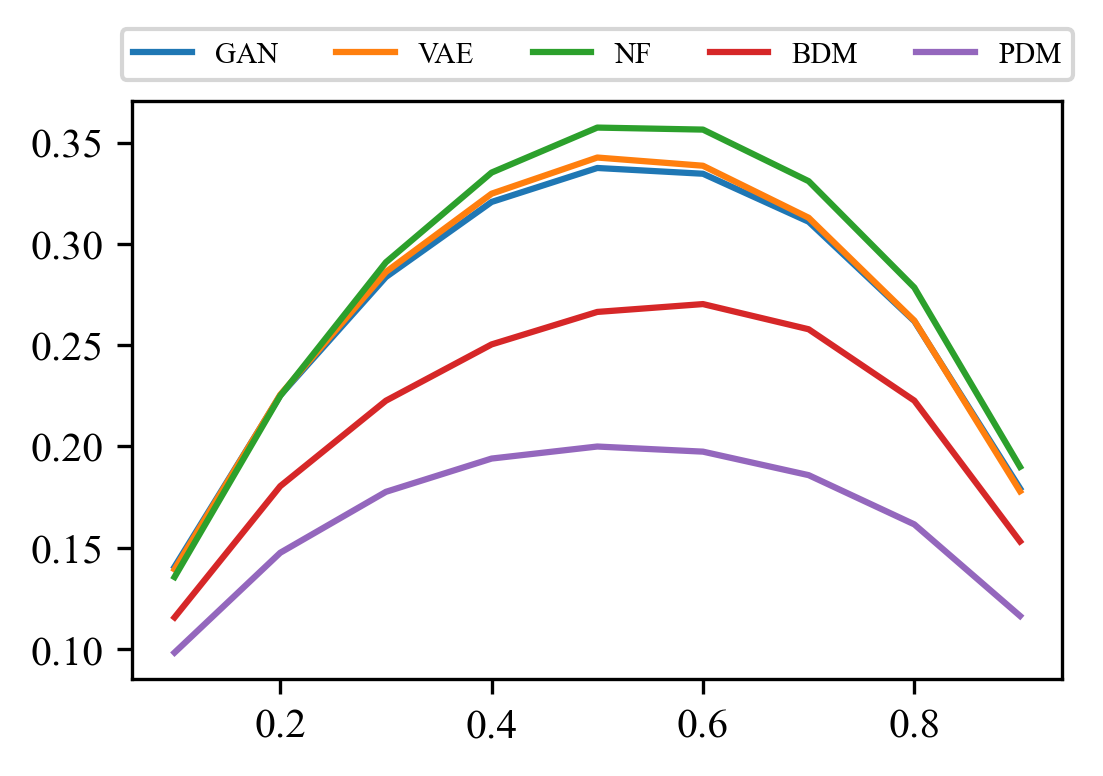

In [66]:
plt.figure(figsize=(4, 2.5), dpi=300)
plt.plot(quantiles, ps_gan, label = "GAN")
plt.plot(quantiles, ps_vae, label = "VAE")
plt.plot(quantiles, ps_nf, label = "NF")
plt.plot(quantiles, ps_diff_base, label = "BDM")
plt.plot(quantiles, ps_diff_phy, label = "PDM")
# plt.ylim(0.1, 0.8)
plt.legend(fontsize=7, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5)
# plt.legend(fontsize=8, loc = "upper left")
plt.savefig("./result/plots/PS.jpg")

In [67]:
X.shape, X_hat_gan.shape, X_hat_diff_base.shape, X_hat_diff_phy.shape

(torch.Size([2190, 20, 96]),
 torch.Size([2190, 20, 96]),
 torch.Size([2190, 20, 96]),
 torch.Size([2190, 20, 96]))

In [68]:
def es(x, x_hat):
    es = 0
    term_1 = 0
    term_2 = 0
    M = x.shape[0]
    for i in range(M):
        term_1 = term_1 + torch.norm(x_hat[i] - x[i])
        for j in range(M):
            term_2 = term_2 + torch.norm(x_hat[i]- x_hat[j])
    es = es + term_1 /M  - term_2 / (2 * M**2)
    return es

In [69]:
def crps(x, x_hat):
    crps = 0
    term_1 = 0
    term_2 = 0
    M = len(x)
    for i in range(M):
        term_1 = term_1 + torch.abs(x_hat[i] - x[i])
        for j in range(M):
            term_2 = term_2 + torch.abs(x_hat[i]- x_hat[j])
    crps = crps + term_1 /M  - term_2 / (2 * M**2)
    return crps

In [70]:
def vs(x, x_hat):
    x = x.T
    x_hat = x_hat.T # [96, 20]
    T = x.shape[0]
    vs = 0
    for i in range(T):
            for j in range(i+1, T):
                term_1 = torch.sqrt(torch.abs(x[i][0] - x[j][0]))
                term_2 = torch.mean(torch.sqrt(torch.abs(x_hat[i] - x_hat[j])))
                vs = vs + (term_1 - term_2) ** 2
    return vs
    

In [71]:
def crps_margin(X, X_hat):
    # CRPS
    TS = X.shape[0] # num of test data
    T = X.shape[2]
    CRPS = []
    for i in tqdm(range(T)):
        temp = 0
        for j in range(TS):
            x = X[j, :, i]
            x_hat = X_hat[j, :, i]
            temp = temp + crps(x, x_hat)
        CRPS.append(temp/TS)
    return CRPS

In [72]:
CRPS_gan = crps_margin(X, X_hat_gan)
CRPS_vae = crps_margin(X, X_hat_vae)
CRPS_nf = crps_margin(X, X_hat_nf)
CRPS_diff_base = crps_margin(X, X_hat_diff_base)
CRPS_diff_phy = crps_margin(X, X_hat_diff_phy)


100%|██████████| 96/96 [08:06<00:00,  5.06s/it]


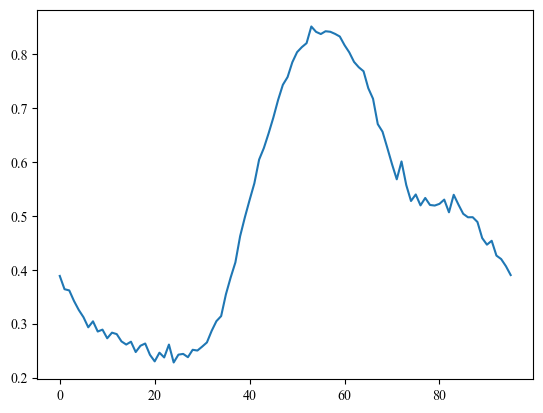

In [73]:
plt.plot(CRPS_gan)

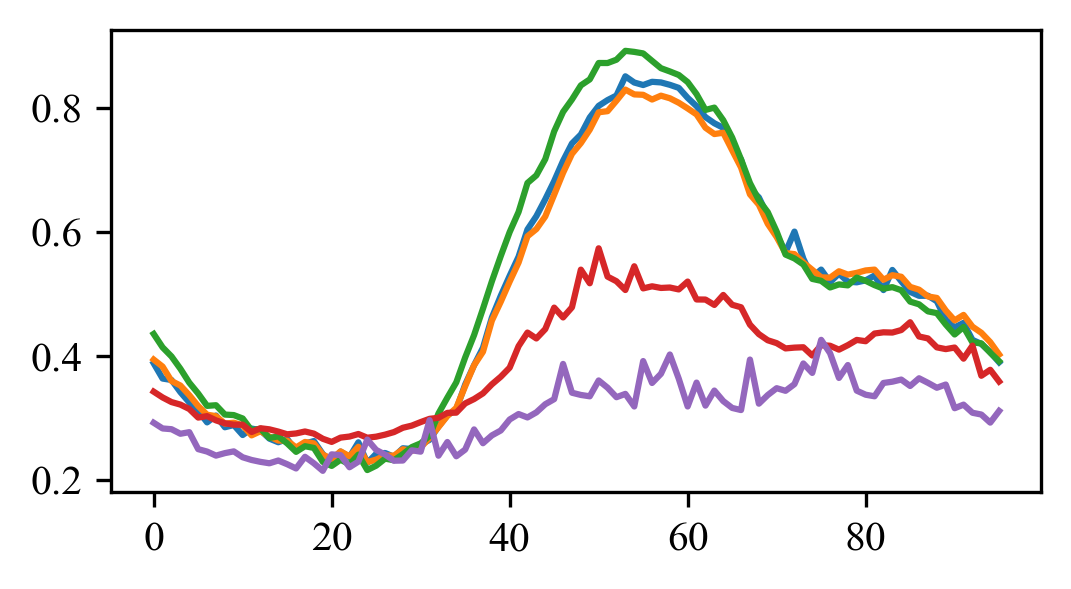

In [74]:
plt.figure(figsize=(4, 2), dpi=300)
plt.plot(CRPS_gan, label = "GAN")
plt.plot(CRPS_vae, label = "VAE")
plt.plot(CRPS_nf, label = "NF")
plt.plot(CRPS_diff_base, label = "BDM")
plt.plot(CRPS_diff_phy, label = "PDM")
# plt.legend(fontsize=8)
plt.savefig("./result/plots/CRPS.jpg")

Load Forecasting Metric: MAE and RMSE

In [75]:
def evaluation(X, X_hat):
    TS = X.shape[0] # num of test data
    M = X.shape[1] # num of senarios
    T = X.shape[2]
    # MAE; RMSE
    MAE = 0
    RMSE = 0
    
    for i in tqdm(range(TS)):
        for j in range(M):
            x = X[i, j, :]
            x_hat = X_hat[i, j, :]
            MAE = MAE + mean_absolute_error(x,x_hat)
            RMSE = RMSE + mean_squared_error(x, x_hat)
    MAE = MAE / (TS * M)
    RMSE = RMSE / (TS * M)
    print(f'MAE: {MAE:.4f}')
    print(f'RMSE: {RMSE:.4f}')
    # PS
    PS = np.mean(pinball_Loss(X, X_hat))
    print(f'PS: {PS:.4f}')
    # CRPS
    CRPS = 0
    for i in tqdm(range(T)):
        for j in range(TS):
            x = X[j, :, i]
            x_hat = X_hat[j, :, i]
            CRPS = CRPS + crps(x, x_hat)
    CRPS = CRPS / (T * TS)
    print(f'CRPS: {CRPS:.4f}')
    # ES
    ES = 0
    for i in tqdm(range(TS)):
        x = X[i]
        x_hat = X_hat[i]
        ES = ES + es(x, x_hat)
    ES = ES / TS
    print(f'ES: {ES:.4f}')
    # VS
    VS = 0
    for i in tqdm(range(TS)):
        VS = VS + vs(X[i], X_hat[i])
    VS = VS / TS
    print(f'VS: {VS:.4f}')


In [76]:
evaluation(X, X_hat_nf)

100%|██████████| 2190/2190 [00:16<00:00, 130.01it/s]


MAE: 0.9574
RMSE: 1.9011
PS: 0.2778


100%|██████████| 96/96 [08:10<00:00,  5.11s/it]


CRPS: 0.5092


100%|██████████| 2190/2190 [00:07<00:00, 311.35it/s]


ES: 6.8487


100%|██████████| 2190/2190 [03:51<00:00,  9.45it/s]

VS: 1140.9404


In [77]:
evaluation(X, X_hat_vae)

100%|██████████| 2190/2190 [00:17<00:00, 126.37it/s]


MAE: 0.8825
RMSE: 1.5551
PS: 0.2678


100%|██████████| 96/96 [08:07<00:00,  5.08s/it]


CRPS: 0.4897


100%|██████████| 2190/2190 [00:07<00:00, 308.16it/s]


ES: 6.3725


100%|██████████| 2190/2190 [03:50<00:00,  9.50it/s]

VS: 967.4344


In [78]:
evaluation(X, X_hat_gan)

  0%|          | 0/2190 [00:00<?, ?it/s]

100%|██████████| 2190/2190 [00:16<00:00, 129.25it/s]


MAE: 0.8859
RMSE: 1.5786
PS: 0.2661


100%|██████████| 96/96 [08:11<00:00,  5.12s/it]


CRPS: 0.4926


100%|██████████| 2190/2190 [00:07<00:00, 311.94it/s]


ES: 6.4477


100%|██████████| 2190/2190 [03:51<00:00,  9.47it/s]

VS: 975.4125


In [79]:
evaluation(X, X_hat_diff_phy)

100%|██████████| 2190/2190 [00:16<00:00, 129.37it/s]


MAE: 0.5846
RMSE: 0.6385
PS: 0.1643


100%|██████████| 96/96 [08:09<00:00,  5.10s/it]


CRPS: 0.3049


100%|██████████| 2190/2190 [00:06<00:00, 318.18it/s]


ES: 3.7858


100%|██████████| 2190/2190 [03:50<00:00,  9.50it/s]

VS: 548.9347


In [80]:
evaluation(X, X_hat_diff_base)

100%|██████████| 2190/2190 [00:17<00:00, 128.47it/s]


MAE: 0.8665
RMSE: 1.2816
PS: 0.2155


100%|██████████| 96/96 [08:09<00:00,  5.10s/it]


CRPS: 0.3878


100%|██████████| 2190/2190 [00:06<00:00, 316.71it/s]


ES: 4.8046


100%|██████████| 2190/2190 [03:49<00:00,  9.56it/s]

VS: 850.5711
